# Hito 0

En este cuaderno se realizará el preprocesado y la estracción de características de los datos EEG, EOG y PERCLOS.

Una vez definidas las funciones de preprocesamiento, se tomarán los datos raw de cada cliente y se generará un archivo CSV con los datos preprocesados para cada cliente.

# Pre-processing

In [9]:
!pip install mne
!pip install neurokit2
!pip install pymatreader

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [10]:
import mne

from pymatreader import read_mat

import neurokit2 as nk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats

## PSD

EEG features (PSD, DE) from five frequency bands: delta (1-4 Hz), theta (4-8 Hz), alpha (8-14 Hz), beta (14-31 Hz), and gamma (31-50 Hz)

i) psd_movingAve: PSD with moving average

ii) psd_LDS: PSD with linear dynamic system

iii) de_movingAve: DE with moving average

iv) de_LDS: DE with linear dynamic system

The data format is channel\*sample_number\*frequency_bands (17\*885\*5). The first 1-5 in the first dimension 'channel' are corresponding to temporal brain areas, and the last 7-17 are corresponding to posterior brain areas.

**Se extraerá el PSD de cada banda de frecuencia a partir del promedio de cada canal.**

In [11]:
def get_psd_data(client):
    mat_data = read_mat("./data/SEED-VIG/EEG_Feature_5Bands/" + client)
    
    n_channels = 17
    n_samples = 885
    n_bands = 5
    
    # Se calcula la media de cada banda a lo largo de los 17 canales
    PSD = {
        "psd_delta": np.zeros(n_samples),
        "psd_theta": np.zeros(n_samples),
        "psd_alpha": np.zeros(n_samples),
        "psd_beta": np.zeros(n_samples),
        "psd_gamma": np.zeros(n_samples)
    }

    for s in range(n_samples):
        avg_psd = np.zeros(5)
        for b in range(n_bands):
            for c in range(n_channels):
                #print(mat_data["psd_movingAve"][c][s][b])
                avg_psd[b] += mat_data["psd_movingAve"][c][s][b]

        PSD["psd_delta"][s] = avg_psd[0]
        PSD["psd_theta"][s] = avg_psd[1]
        PSD["psd_alpha"][s] = avg_psd[2]
        PSD["psd_beta"][s] = avg_psd[3]
        PSD["psd_gamma"][s] = avg_psd[4]
    
    psd_df = pd.DataFrame.from_dict(PSD)
    
    return psd_df

## EOG

Se extraerá el número de parpadeos y la varianza de la señal para el canal Vertical del EOG.

In [12]:
def clean_eog(data, sampling_rate=125, method='neurokit'):
    return nk.eog_clean(data, sampling_rate=sampling_rate, method=method)

def amend_outliers_eog(data):
    data = abs(data)
    thresh=np.percentile(data, 99.5)

    data_o = []
    for el in data:
        if el > thresh:
            el = thresh
        
        data_o.append(el)
    
    return data_o

def make_epochs(eog, samples_per_epoch=1000):
    epochs = []
    for e in range(len(eog)//samples_per_epoch):
        epochs.append(eog[e*samples_per_epoch:(e+1)*samples_per_epoch])
    
    return np.array(epochs)

def eog_epochs_get_features(eog_epochs, thresh):
    eog_blinks = []
    eog_var = []
    
    for e in range(len(eog_epochs)):
        data = eog_epochs[e]
        
        # abs de nuevo por si no se usa el remove_outliers_eog()
        blinks = mne.preprocessing.peak_finder(abs(data), thresh=thresh, extrema=1, verbose=False)

        eog_blinks.append(len(blinks[0]))
        eog_var.append(data.var())
    
    return np.array(eog_blinks), np.array(eog_var)

def get_eog_data(client):
    mat_data = read_mat("./data/SEED-VIG/Raw_Data/" + client)

    eogv = mat_data['EOG']['eog_v']*1e-6
    eogv_clean = clean_eog(eogv)
    eogv_clean_o = amend_outliers_eog(eogv_clean)

    eog_epochs = make_epochs(eogv_clean_o, 1000)

    thresh = np.percentile(eogv_clean_o, 95)
    eog_blinks, eog_var = eog_epochs_get_features(eog_epochs, thresh)
    
    data = {
        "eog_blinks": eog_blinks,
        "eog_var": eog_var
    }
    
    eog_df = pd.DataFrame.from_dict(data)
    
    return eog_df

In [48]:
client = "4_20151105_noon.mat"

mat_data = read_mat("./data/SEED-VIG/Raw_Data/" + client)

eogv = mat_data['EOG']['eog_v']*1e-6
eogv_clean = clean_eog(eogv)
eogv_clean_o = amend_outliers_eog(eogv_clean)

thresh = np.percentile(eogv_clean_o, 95)

eog_epochs = make_epochs(eogv_clean_o, 1000)

In [67]:
global_blinks = []

for e in range(3):
    data = eog_epochs[e]
        
    # abs de nuevo por si no se usa el remove_outliers_eog()
    blinks = mne.preprocessing.peak_finder(abs(data), thresh=thresh, extrema=1, verbose=False)
    
    global_blinks.append(list(np.array(blinks[0]/125)+(8*e)))
    
flat_global_blinks = [item for sublist in global_blinks for item in sublist]
flat_global_blinks

[4.824, 5.776, 7.536, 11.48, 14.088000000000001, 18.4, 22.968]

In [50]:
import matplotlib.pyplot as plt

t = np.array(range(0, 3*len(eog_epochs[0])))

y1 = np.array(eog_epochs[0])
y2 = np.array(eog_epochs[1])
y3 = np.array(eog_epochs[2])

y = np.concatenate((y1,y2,y3))

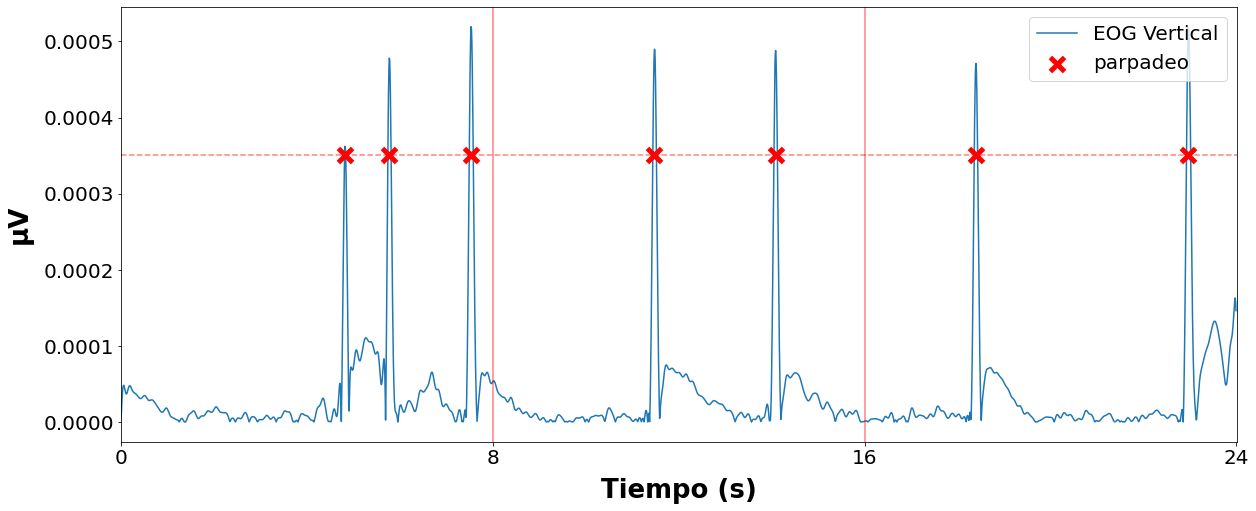

In [89]:
plt.figure(figsize=(20,8))

plt.plot(t/125, y, zorder=0, label="EOG Vertical")

plt.axhline(thresh, c='r', linestyle='--', zorder=0, alpha=0.5)

plt.axvline(8, c='r', alpha=0.5)
plt.axvline(16, c='r', alpha=0.5)

plt.scatter(flat_global_blinks, np.repeat(thresh, len(flat_global_blinks)), c='r', s=200, linewidths=5, marker='x', zorder=1, label='parpadeo')

plt.xlim(0, 24.01)

size_label = 26
plt.xlabel('Tiempo (s)', fontweight ='bold', labelpad = 10,fontsize = size_label)
plt.ylabel('μV', fontweight ='bold', labelpad = 10,fontsize = size_label)

size_ticks = 20; plt.xticks([0,8,16,24],fontsize=size_ticks); plt.yticks(fontsize=size_ticks);
size_legend = 20; plt.legend(loc='upper right', fontsize = size_legend)
plt.savefig("./results/EOG_deteccion_parpadeos.pdf", bbox_inches='tight')
plt.show()

## PERCLOS

Se almacenarán los datos:
- raw, intervalo [0 -1]
- discretizados, False = Despierto; True = Somnoliento

In [13]:
def get_perclos_labels(client):
    mat_data = read_mat("data/SEED-VIG/perclos_labels/" + client)

    perclos = mat_data["perclos"]
    boundary = min(perclos) + (max(perclos)-min(perclos))*0.25
    
    # TRUE=Somnoliento; False=Despierto
    y = perclos >= boundary
    
    data = {
        "y_reg": perclos,
        "y_class": y
    }
    
    perclos_df = pd.DataFrame.from_dict(data)
    
    return perclos_df

## Resultado

Se muestra el dataframe resultante tras aplicar el preprocesado y extraccion de características para un cliente del dataset

In [14]:
def get_client_data(client):
    psd = get_psd_data(client)
    
    eog = get_eog_data(client)
    
    perclos = get_perclos_labels(client)
    
    client_data = psd.join(eog.join(perclos))
    return client_data

def client_remove_psd_outliers(client_data):
    z = stats.zscore(client_data[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma']])
    client_data_o = client_data[(z < 3).all(axis=1)]
    
    return client_data_o

In [41]:
client = "18_20150926_noon.mat"
client_data = get_client_data(client)

client_data_o = client_remove_psd_outliers(client_data)

client_data_o

,psd_delta,psd_theta,psd_alpha,psd_beta,psd_gamma,eog_blinks,eog_var,y_reg,y_class
0,6.999198e+06,1.851912e+06,638946.782370,388136.052353,224085.539611,5,6.400181e-09,0.285217,False
1,4.336626e+06,8.455721e+05,691864.523608,302993.216781,160214.061150,4,2.549366e-09,0.318094,False
2,6.012465e+06,1.075922e+06,506950.161982,357392.049073,174394.097226,1,1.580665e-09,0.339400,True
3,8.672925e+06,9.387626e+05,520973.650245,271533.321277,135426.910339,3,2.433784e-09,0.344124,True
4,6.047004e+06,1.253480e+06,394803.384113,305521.950704,167811.157718,4,3.558069e-09,0.356346,True
...,...,...,...,...,...,...,...,...,...
880,7.379965e+06,1.344927e+06,525646.937208,401727.171304,353890.472318,3,3.266126e-09,0.295166,False
881,5.818732e+06,1.284721e+06,482326.967848,244935.702215,141096.239727,7,8.107354e-09,0.294018,False
882,6.101910e+06,1.336721e+06,496443.033236,251382.589212,161901.070173,7,1.000420e-08,0.292964,False
883,5.760702e+06,1.269146e+06,490467.522595,237636.280501,146994.686433,1,1.572221e-09,0.290991,False


In [14]:
client_data_o.to_csv("./data/test.csv", index=False, header=True)

In [15]:
pd.read_csv("./data/test.csv")

,psd_delta,psd_theta,psd_alpha,psd_beta,psd_gamma,eog_blinks,eog_var,y_reg,y_class
0,13057090.0,1945167.0,835064.0,582382.0,503923.0,0,1.037713e-10,0.119233,False
1,13161134.0,1744527.0,736466.0,525029.0,423829.0,1,6.786951e-09,0.149089,False
2,6110325.0,1538632.0,763933.0,498000.0,454346.0,2,7.330638e-09,0.177563,False
3,6245159.0,1476258.0,642524.0,461092.0,484130.0,2,2.657537e-09,0.194524,False
4,21925572.0,1996168.0,865699.0,524286.0,469602.0,2,3.379798e-09,0.220294,False
...,...,...,...,...,...,...,...,...,...
838,291581314.0,12516012.0,3184157.0,248220.0,33413.0,0,1.680135e-10,1.000000,True
839,234869058.0,11851006.0,3141714.0,248768.0,33365.0,0,2.110112e-10,1.000000,True
840,255784531.0,11687640.0,3077573.0,250154.0,33336.0,0,3.495151e-10,1.000000,True
841,259054942.0,12256428.0,3054228.0,250139.0,33420.0,0,1.641842e-10,1.000000,True


# Script de ejecucion

Mediante el siguiente código se generarán los ficheros CSV correspondientes a cada cliente, se agruparán de la siguiente manera:

- Empresa_1: Clientes con id **PAR**
- Empresa_2: Clientes con id **IMPAR**

Si un cliente tiene varios ficheros de datos asociados, simplemente se "stackean" en el mismo fichero CSV.

In [ ]:
from os import listdir, path
import re

for f in listdir("./data/SEED-VIG/Raw_Data/"):
    m = re.search("(.{1,2})_.*", f)
    if m:
        num_client = int(m.group(1))
        client = f
        
        client_data = get_client_data(client)
        client_data_o = client_remove_psd_outliers(client_data)
        
        dest_filename = f"./data/horizontal/{(num_client%2)+1}/cliente_{num_client}.csv"
        
        # Si existe ya el fichero => sujeto con dos experimentos => se 'stackean' los dataframes para generar uno mas grande
        if path.exists(dest_filename):
            existing_client_data = pd.read_csv(dest_filename)
            
            client_data_o = pd.concat([existing_client_data, client_data_o])
        
        client_data_o.to_csv(f"./data/horizontal/{(num_client%2)+1}/cliente_{num_client}.csv", index=False, header=True)